<a href="https://colab.research.google.com/github/asheta66/Generative-AI-2/blob/main/2_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow matplotlib numpy scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mount Google Drive if using Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Set paths and parameters
data_dir = '/content/drive/My Drive/data3/128x128'
img_height, img_width = 128, 128
batch_size = 32
epochs = 10

# Load and preprocess data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


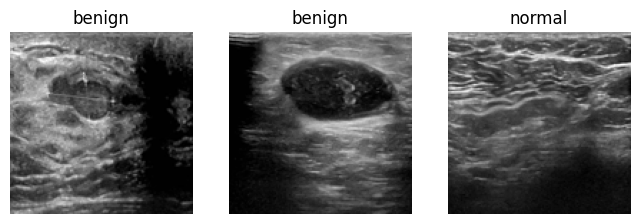

In [7]:
# Display one sample image from each class
def show_sample_images(generator):
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(8, 3))
    for i in range(len(class_names)):
        img, label = next(generator)  # Use next() to get a batch
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img[0].reshape(img_height, img_width), cmap='gray')
        plt.title(class_names[int(label[0])])
        plt.axis('off')
    plt.show()

show_sample_images(train_data)

In [ ]:
# Define the autoencoder model
def build_autoencoder(input_shape, hidden_size):
    input_img = Input(shape=input_shape)
    x = Flatten()(input_img)
    x = Dense(hidden_size, activation='relu')(x)
    encoded = Dense(hidden_size // 2, activation='relu')(x)

    x = Dense(hidden_size, activation='relu')(encoded)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Define the classifier model
def build_classifier(encoded_input_shape, num_classes):
    encoded_input = Input(shape=encoded_input_shape)
    x = Dense(64, activation='relu')(encoded_input)
    x = Dense(num_classes, activation='softmax')(x)

    classifier = Model(encoded_input, x)
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [ ]:
# Create autoencoders and classifier
autoencoder1, encoder1 = build_autoencoder((img_height, img_width, 1), 512)
autoencoder2, encoder2 = build_autoencoder((128, 128), 256)
classifier = build_classifier((128, 128), len(train_data.class_indices))

# Train first autoencoder
history1 = autoencoder1.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1
)

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step


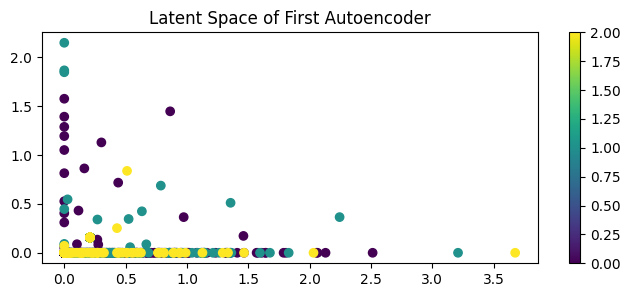

In [10]:
# Show latent space of first autoencoder
encoded_imgs1 = encoder1.predict(train_data)
plt.figure(figsize=(8,3))
plt.scatter(encoded_imgs1[:, 0], encoded_imgs1[:, 1], c=train_data.classes, cmap='viridis')
plt.colorbar()
plt.title('Latent Space of First Autoencoder')
plt.show()

In [ ]:
# # Train second autoencoder
# history2 = autoencoder2.fit(
#     encoder1.predict(train_data),
#     encoder1.predict(val_data),
#     epochs=10,
#     verbose=1
# )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'path_to_train_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)

val_generator = datagen.flow_from_directory(
    'path_to_val_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)

# Train autoencoder2 using the data generators
history2 = autoencoder2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

In [ ]:
# Show latent space of second autoencoder
encoded_imgs2 = encoder2.predict(encoder1.predict(train_data))
plt.figure(figsize=(10, 10))
plt.scatter(encoded_imgs2[:, 0], encoded_imgs2[:, 1], c=train_data.classes, cmap='viridis')
plt.colorbar()
plt.title('Latent Space of Second Autoencoder')
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Autoencoder 1 Loss')
plt.plot(history2.history['loss'], label='Autoencoder 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Autoencoder 1 Accuracy')
plt.plot(history2.history['accuracy'], label='Autoencoder 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Train classifier
history_class = classifier.fit(
    encoder2.predict(encoder1.predict(train_data)),
    train_data.classes,
    validation_data=(encoder2.predict(encoder1.predict(val_data)), val_data.classes),
    epochs=epochs,
    verbose=1
)

# Predict and evaluate
y_pred = np.argmax(classifier.predict(encoder2.predict(encoder1.predict(val_data))), axis=1)

# Calculate metrics
accuracy = accuracy_score(val_data.classes, y_pred)
precision = precision_score(val_data.classes, y_pred, average='weighted')
recall = recall_score(val_data.classes, y_pred, average='weighted')
f1 = f1_score(val_data.classes, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Show original and reconstructed images
def show_reconstructed_images(autoencoder, encoder, data_generator):
    class_names = list(data_generator.class_indices.keys())
    plt.figure(figsize=(10, 10))
    for i in range(len(class_names)):
        img, label = data_generator.next()
        encoded_img = encoder.predict(img)
        decoded_img = autoencoder.predict(encoded_img)

        plt.subplot(len(class_names), 3, i*3 + 1)
        plt.imshow(img[0].reshape(img_height, img_width), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(len(class_names), 3, i*3 + 2)
        plt.imshow(decoded_img[0].reshape(img_height, img_width), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        plt.subplot(len(class_names), 3, i*3 + 3)
        plt.imshow(encoded_img[0].reshape((16, 16)), cmap='gray')  # Adjust according to latent space size
        plt.title('Latent')
        plt.axis('off')

    plt.show()

show_reconstructed_images(autoencoder2, encoder2, val_data)
